In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for plots
sns.set_theme(style="whitegrid")

print(f"NumPy Version: {np.__version__}")

NumPy Version: 2.0.2


### Part 1: Defining a Simple MDP Environment (Grid World)

We'll define a classic grid-world environment. This simple model allows for intuitive understanding of states, actions, transitions, and rewards.

**Grid World Description:**
* A 3x4 grid.
* States are (row, column) tuples.
* Actions: 'up', 'down', 'left', 'right'.
* Special states:
    * (0, 3): Goal state with reward +1. (Terminal State)
    * (1, 3): Trap state with reward -1. (Terminal State)
    * (1, 1): Blocked state (cannot be entered).
* All other states give a small negative reward (-0.04) per step to encourage finding shorter paths (a common practice in RL).
* Stochastic Transitions: Taking an action (e.g., 'up') moves the agent in the intended direction with 80% probability. With 10% probability, it moves left of the intended direction, and with 10% probability, it moves right. If an intended move hits a wall or blocked state, the agent stays in its current state.

**Tasks:**
* Create a grid-world map representation.
* Define the state space, action space.
* Define the transition probabilities $P(s' | s, a)$ and reward function $R(s, a, s')$.
* Illustrate the MDP visually.

In [3]:
print("--- Part 1: Defining a Simple MDP Environment (Grid World) ---")

# Define the Grid World map
# S: Start, G: Goal (+1 reward), T: Trap (-1 reward), #: Blocked, .: Empty
GRID_MAP = [
    ['.', '.', '.', '+1'],
    ['.', '#', '.', '-1'],
    ['S', '.', '.', '.'],
]

NUM_ROWS = len(GRID_MAP)
NUM_COLS = len(GRID_MAP[0])

# Map (row, col) to a unique integer state index
# We'll skip the blocked state (1,1) in our state numbering
# States: (0,0), (0,1), (0,2), (0,3), (1,0), (1,2), (1,3), (2,0), (2,1), (2,2), (2,3)
# Total states: 11 (3*4 - 1 blocked)
state_to_idx = {}
idx_to_state = {}
state_idx_counter = 0

for r in range(NUM_ROWS):
    for c in range(NUM_COLS):
        if GRID_MAP[r][c] != '#':
            state_to_idx[(r, c)] = state_idx_counter
            idx_to_state[state_idx_counter] = (r, c)
            state_idx_counter += 1

NUM_STATES = state_idx_counter
ACTIONS = ['up', 'down', 'left', 'right']
NUM_ACTIONS = len(ACTIONS)

ACTION_DELTAS = {
    'up': (-1, 0),
    'down': (1, 0),
    'left': (0, -1),
    'right': (0, 1),
}

# Define special states
GOAL_STATE_COORD = (0, 3)
TRAP_STATE_COORD = (1, 3)
START_STATE_COORD = (2, 0)
BLOCKED_STATE_COORD = (1, 1) # Will not be a valid state index

# Rewards
LIVING_REWARD = -0.04 # Small negative reward for each step
GOAL_REWARD = 1.0
TRAP_REWARD = -1.0

# Discount Factor
GAMMA = 0.9 # Future rewards are discounted

# Transition Probabilities P(s' | s, a)
# P[s_idx][a_idx][s_prime_idx] = probability
P = np.zeros((NUM_STATES, NUM_ACTIONS, NUM_STATES))

# Reward Function R(s, a, s')
# R[s_idx][a_idx][s_prime_idx] = reward
R = np.zeros((NUM_STATES, NUM_ACTIONS, NUM_STATES))

# Define transition dynamics
for s_coord, s_idx in state_to_idx.items():
    if s_coord == GOAL_STATE_COORD or s_coord == TRAP_STATE_COORD:
        # Terminal states have no outgoing transitions, or they self-loop with 0 reward.
        # For simplicity, we'll model them as self-looping with reward 0
        # as per standard MDP convention for absorbing states once goal/trap is reached.
        P[s_idx, :, s_idx] = 1.0 # Stay in terminal state
        R[s_idx, :, s_idx] = 0.0 # No further reward once absorbed
        continue

    for a_idx, action in enumerate(ACTIONS):
        intended_dr, intended_dc = ACTION_DELTAS[action]

        # Define the actual (s', prob, reward) tuples for this (s, a)
        possible_transitions = []

        # Intended direction (80%)
        next_r_intended = s_coord[0] + intended_dr
        next_c_intended = s_coord[1] + intended_dc
        actual_next_coord_intended = (next_r_intended, next_c_intended)

        # Left of intended (10%)
        if action == 'up': left_action = 'left'
        elif action == 'down': left_action = 'right'
        elif action == 'left': left_action = 'down'
        elif action == 'right': left_action = 'up'
        dr_left, dc_left = ACTION_DELTAS[left_action]
        next_r_left = s_coord[0] + dr_left
        next_c_left = s_coord[1] + dc_left
        actual_next_coord_left = (next_r_left, next_c_left)

        # Right of intended (10%)
        if action == 'up': right_action = 'right'
        elif action == 'down': right_action = 'left'
        elif action == 'left': right_action = 'up'
        elif action == 'right': right_action = 'down'
        dr_right, dc_right = ACTION_DELTAS[right_action]
        next_r_right = s_coord[0] + dr_right
        next_c_right = s_coord[1] + dc_right
        actual_next_coord_right = (next_r_right, next_c_right)

        # Helper to get actual next state and reward, handling boundaries/blocked states
        def get_actual_outcome(target_coord):
            r, c = target_coord
            if not (0 <= r < NUM_ROWS and 0 <= c < NUM_COLS) or GRID_MAP[r][c] == '#':
                # If hit wall or blocked, stay in current state
                return s_coord, LIVING_REWARD
            elif target_coord == GOAL_STATE_COORD:
                return target_coord, GOAL_REWARD
            elif target_coord == TRAP_STATE_COORD:
                return target_coord, TRAP_REWARD
            else:
                return target_coord, LIVING_REWARD

        outcomes = {
            get_actual_outcome(actual_next_coord_intended): 0.8,
            get_actual_outcome(actual_next_coord_left): 0.1,
            get_actual_outcome(actual_next_coord_right): 0.1,
        }

        # Aggregate probabilities for same next state (due to wall/blocked collisions)
        aggregated_outcomes = {}
        for (next_s_coord, reward), prob in outcomes.items():
            if next_s_coord not in aggregated_outcomes:
                aggregated_outcomes[next_s_coord] = {'prob_sum': 0.0, 'reward': reward}
            aggregated_outcomes[next_s_coord]['prob_sum'] += prob

        for next_s_coord, data in aggregated_outcomes.items():
            next_s_idx = state_to_idx[next_s_coord]
            P[s_idx, a_idx, next_s_idx] = data['prob_sum']
            R[s_idx, a_idx, next_s_idx] = data['reward'] # Reward is for reaching s'

# Verify probabilities sum to 1 for each (s,a)
for s_idx in range(NUM_STATES):
    for a_idx in range(NUM_ACTIONS):
        if not np.isclose(P[s_idx, a_idx, :].sum(), 1.0):
             # For terminal states, sum might not be 1 if we don't explicitly set their self-loop as 1.0 everywhere.
             # We already handled this by ensuring self-looping for terminal states.
            print(f"Warning: Probabilities for state {idx_to_state[s_idx]}, action {ACTIONS[a_idx]} do not sum to 1.0: {P[s_idx, a_idx, :].sum()}")


print(f"Grid Dimensions: {NUM_ROWS}x{NUM_COLS}")
print(f"Number of States (excluding blocked): {NUM_STATES}")
print(f"State to Index Mapping: {state_to_idx}")
print(f"Index to State Mapping: {idx_to_state}")
print(f"Actions: {ACTIONS}")
print(f"Discount Factor (Gamma): {GAMMA}")
print(f"Living Reward: {LIVING_REWARD}")

--- Part 1: Defining a Simple MDP Environment (Grid World) ---
Grid Dimensions: 3x4
Number of States (excluding blocked): 11
State to Index Mapping: {(0, 0): 0, (0, 1): 1, (0, 2): 2, (0, 3): 3, (1, 0): 4, (1, 2): 5, (1, 3): 6, (2, 0): 7, (2, 1): 8, (2, 2): 9, (2, 3): 10}
Index to State Mapping: {0: (0, 0), 1: (0, 1), 2: (0, 2), 3: (0, 3), 4: (1, 0), 5: (1, 2), 6: (1, 3), 7: (2, 0), 8: (2, 1), 9: (2, 2), 10: (2, 3)}
Actions: ['up', 'down', 'left', 'right']
Discount Factor (Gamma): 0.9
Living Reward: -0.04


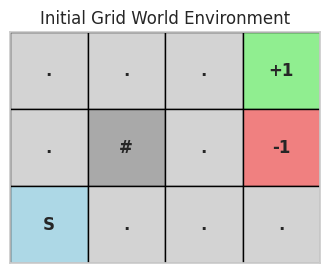

In [4]:
# Visualization of the Grid World
def plot_grid(values=None, policy=None, title="Grid World"):
    fig, ax = plt.subplots(figsize=(NUM_COLS, NUM_ROWS))
    ax.set_xlim(-0.5, NUM_COLS - 0.5)
    ax.set_ylim(-0.5, NUM_ROWS - 0.5)
    ax.set_xticks(np.arange(-0.5, NUM_COLS, 1))
    ax.set_yticks(np.arange(-0.5, NUM_ROWS, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(True)
    ax.invert_yaxis() # (0,0) at top-left

    # Draw cells
    for r in range(NUM_ROWS):
        for c in range(NUM_COLS):
            cell_char = GRID_MAP[r][c]
            color = 'lightgray'
            text_label = ''

            if (r, c) == START_STATE_COORD:
                text_label = 'S'
                color = 'lightblue'
            elif (r, c) == GOAL_STATE_COORD:
                text_label = '+1'
                color = 'lightgreen'
            elif (r, c) == TRAP_STATE_COORD:
                text_label = '-1'
                color = 'lightcoral'
            elif cell_char == '#':
                text_label = '#'
                color = 'darkgray'
            else:
                text_label = '.'

            ax.add_patch(plt.Rectangle((c - 0.5, r - 0.5), 1, 1, edgecolor='black', facecolor=color, linewidth=1))
            ax.text(c, r, text_label, ha='center', va='center', fontsize=12, fontweight='bold')

            # Display values if provided
            if values is not None and (r, c) in state_to_idx:
                s_idx = state_to_idx[(r, c)]
                if (r, c) == GOAL_STATE_COORD or (r, c) == TRAP_STATE_COORD:
                    ax.text(c, r + 0.3, f"{values[s_idx]:.2f}", ha='center', va='center', fontsize=9, color='darkblue')
                else:
                    ax.text(c, r + 0.3, f"{values[s_idx]:.2f}", ha='center', va='center', fontsize=9, color='darkblue')

            # Display policy if provided
            if policy is not None and (r, c) in state_to_idx and (r, c) != GOAL_STATE_COORD and (r, c) != TRAP_STATE_COORD:
                action_idx = policy[state_to_idx[(r,c)]]
                action_name = ACTIONS[action_idx]
                if action_name == 'up': arrow = '↑'
                elif action_name == 'down': arrow = '↓'
                elif action_name == 'left': arrow = '←'
                elif action_name == 'right': arrow = '→'
                ax.text(c, r - 0.3, arrow, ha='center', va='center', fontsize=15, color='darkred', fontweight='bold')


    ax.set_title(title)
    plt.show()

plot_grid(title="Initial Grid World Environment")

**Discussion Point:**
* Why is the `(1,1)` cell not considered a state? How does the MDP handle hitting walls or blocked cells?
* Explain the purpose of the small negative `LIVING_REWARD`. What would happen if it were 0 or a positive value?


### Part 2: The Evaluation Problem - Policy Evaluation

Given a fixed policy $\pi$, the policy evaluation problem is to compute the state-value function $V^\pi(s)$, which represents the expected total discounted reward starting from state $s$ and following policy $\pi$.

The Bellman expectation equation for $V^\pi(s)$ is:
$V^\pi(s) = \sum_{a \in A} \pi(a|s) \sum_{s' \in S} P(s'|s,a) [R(s,a,s') + \gamma V^\pi(s')]$

We will solve this iteratively until $V^\pi(s)$ converges.

**Tasks:**
* Define a non-optimal (e.g., random or simple deterministic) policy.
* Implement the Policy Evaluation algorithm.
* Calculate and visualize the state-value function for this policy.

In [5]:
print("\n--- Part 2: The Evaluation Problem - Policy Evaluation ---")

# Define a simple policy: Always go 'up' if possible, otherwise 'right'
# This is a deterministic policy (π(a|s) = 1 for one action, 0 for others)
# Policy is an array mapping state index to action index
initial_policy = np.zeros(NUM_STATES, dtype=int)
for s_idx in range(NUM_STATES):
    r, c = idx_to_state[s_idx]
    if (r, c) == GOAL_STATE_COORD or (r, c) == TRAP_STATE_COORD:
        initial_policy[s_idx] = ACTIONS.index('up') # Action doesn't matter for terminal states
        continue
    # Try to go up
    if r > 0 and GRID_MAP[r-1][c] != '#':
        initial_policy[s_idx] = ACTIONS.index('up')
    # Otherwise, try to go right
    elif c < NUM_COLS - 1 and GRID_MAP[r][c+1] != '#':
        initial_policy[s_idx] = ACTIONS.index('right')
    else: # Fallback to 'up' or 'right' if no other options are "better" based on this simple logic
        initial_policy[s_idx] = ACTIONS.index('up') # Default or arbitrary action



--- Part 2: The Evaluation Problem - Policy Evaluation ---


In [6]:
print(f"Initial Policy (State Index -> Action Index): {initial_policy}")

# Policy Evaluation Algorithm
def policy_evaluation(policy, P, R, gamma, num_states, theta=1e-6, max_iterations=1000):
    V = np.zeros(num_states) # Initialize value function to zeros

    for i in range(max_iterations):
        delta = 0 # To check for convergence
        for s_idx in range(num_states):
            v_old = V[s_idx]
            # For terminal states, their value is fixed (their reward at that state)
            # We already set the P and R matrices to reflect absorption with 0 future reward
            # So, the Bellman equation will naturally resolve to their terminal reward.
            if idx_to_state[s_idx] == GOAL_STATE_COORD: # Or GRID_MAP[r][c] == '+1'
                V[s_idx] = GOAL_REWARD
                continue
            if idx_to_state[s_idx] == TRAP_STATE_COORD: # Or GRID_MAP[r][c] == '-1'
                V[s_idx] = TRAP_REWARD
                continue

            a_idx = policy[s_idx] # Get the action prescribed by the policy
            sum_of_future_values = 0
            for s_prime_idx in range(num_states):
                prob = P[s_idx, a_idx, s_prime_idx]
                reward = R[s_idx, a_idx, s_prime_idx]
                sum_of_future_values += prob * (reward + gamma * V[s_prime_idx])
            V[s_idx] = sum_of_future_values
            delta = max(delta, abs(v_old - V[s_idx]))

        if delta < theta:
            print(f"Policy Evaluation converged after {i+1} iterations.")
            break
    else:
        print(f"Policy Evaluation did NOT converge within {max_iterations} iterations.")
    return V

# Run policy evaluation
V_initial_policy = policy_evaluation(initial_policy, P, R, GAMMA, NUM_STATES)
print(f"\nValue Function for Initial Policy:\n{V_initial_policy}")

Initial Policy (State Index -> Action Index): [3 3 3 0 0 0 0 0 3 0 0]
Policy Evaluation converged after 14 iterations.

Value Function for Initial Policy:
[ 1.12025491  1.36558408  1.77594655  1.          0.84679503  1.15679287
 -1.          0.67641293  0.50937143  0.6937889  -1.61050439]


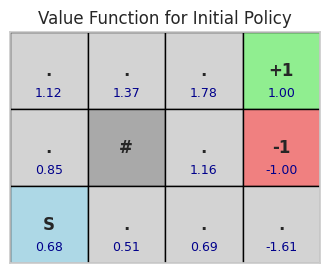

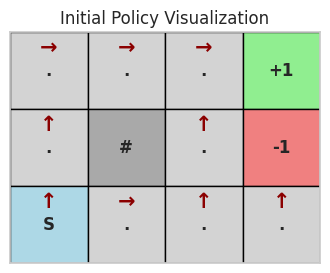

In [7]:
# Visualize the value function for the initial policy
plot_grid(values=V_initial_policy, title="Value Function for Initial Policy")
# Visualize the policy itself
plot_grid(policy=initial_policy, title="Initial Policy Visualization")

**Discussion Point:**
* What does a positive or negative value in $V^\pi(s)$ signify?
* How does the `theta` parameter affect the convergence of Policy Evaluation? What happens if `theta` is too large or too small?


### Part 3: Finding the Optimal Policy - Policy Iteration and Value Iteration

These are dynamic programming algorithms that iteratively improve the policy or value function until the optimal policy $\pi^*$ and optimal value function $V^*(s)$ are found.

#### 3.1 Policy Iteration

Policy Iteration alternates between two steps:
1.  **Policy Evaluation:** Evaluate the current policy $\pi$ to get $V^\pi(s)$ (as done in Part 2).
2.  **Policy Improvement:** Update the policy greedily with respect to the current $V^\pi(s)$. For each state $s$, choose the action $a$ that maximizes the expected future reward:
    $\pi'(s) = \arg\max_a \sum_{s' \in S} P(s'|s,a) [R(s,a,s') + \gamma V^\pi(s')]$
This process repeats until the policy no longer changes (is "stable").

**Tasks:**
* Implement the Policy Improvement step.
* Combine Policy Evaluation and Policy Improvement into the full Policy Iteration algorithm.
* Run and visualize the optimal policy and value function.


--- Part 3.1: Finding the Optimal Policy - Policy Iteration ---
Starting Policy Iteration...
Policy Iteration step 1
Policy Evaluation converged after 58 iterations.
Policy Iteration step 2
Policy Evaluation converged after 41 iterations.
Policy Iteration step 3
Policy Evaluation converged after 13 iterations.
Policy Iteration step 4
Policy Evaluation converged after 14 iterations.
Policy Iteration step 5
Policy Evaluation converged after 14 iterations.
Policy Iteration step 6
Policy Evaluation converged after 14 iterations.
Policy Iteration step 7
Policy Evaluation converged after 14 iterations.
Policy Iteration step 8
Policy Evaluation converged after 14 iterations.
Policy Iteration step 9
Policy Evaluation converged after 14 iterations.
Policy Iteration step 10
Policy Evaluation converged after 14 iterations.
Policy Iteration step 11
Policy Evaluation converged after 14 iterations.
Policy Iteration step 12
Policy Evaluation converged after 14 iterations.
Policy Iteration step 13
Po

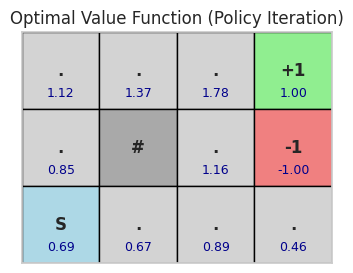

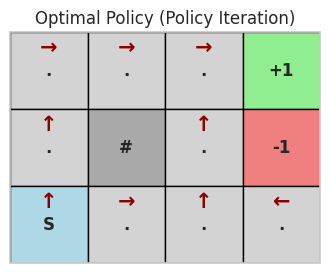

In [8]:
print("\n--- Part 3.1: Finding the Optimal Policy - Policy Iteration ---")

def policy_improvement(V, P, R, gamma, num_states, num_actions):
    policy = np.zeros(num_states, dtype=int)
    policy_stable = True

    for s_idx in range(num_states):
        old_action_idx = policy[s_idx]

        # For terminal states, policy doesn't change
        if idx_to_state[s_idx] == GOAL_STATE_COORD or idx_to_state[s_idx] == TRAP_STATE_COORD:
            policy[s_idx] = old_action_idx # Keep it as is or assign dummy value
            continue

        action_values = np.zeros(num_actions)
        for a_idx in range(num_actions):
            q_sa = 0
            for s_prime_idx in range(num_states):
                prob = P[s_idx, a_idx, s_prime_idx]
                reward = R[s_idx, a_idx, s_prime_idx]
                q_sa += prob * (reward + gamma * V[s_prime_idx])
            action_values[a_idx] = q_sa

        new_action_idx = np.argmax(action_values) # Choose the action that maximizes Q
        policy[s_idx] = new_action_idx

        if new_action_idx != old_action_idx:
            policy_stable = False # Policy has changed

    return policy, policy_stable

def policy_iteration(P, R, gamma, num_states, num_actions, theta=1e-6, max_iter_eval=1000, max_iter_pi=100):
    # Initialize with a random policy
    policy = np.random.randint(0, num_actions, num_states)
    V = np.zeros(num_states) # Initial value function

    print("Starting Policy Iteration...")
    for pi_iter in range(max_iter_pi):
        print(f"Policy Iteration step {pi_iter + 1}")
        # Step 1: Policy Evaluation
        V = policy_evaluation(policy, P, R, gamma, num_states, theta=theta, max_iterations=max_iter_eval)
        # Step 2: Policy Improvement
        new_policy, policy_stable = policy_improvement(V, P, R, gamma, num_states, num_actions)

        if policy_stable:
            print(f"Policy Iteration converged after {pi_iter + 1} iterations.")
            break
        policy = new_policy
    else:
        print(f"Policy Iteration did NOT converge within {max_iter_pi} iterations.")

    return policy, V

# Run Policy Iteration
optimal_policy_pi, optimal_V_pi = policy_iteration(P, R, GAMMA, NUM_STATES, NUM_ACTIONS)

print(f"\nOptimal Value Function (Policy Iteration):\n{optimal_V_pi}")
print(f"Optimal Policy (Policy Iteration):\n{optimal_policy_pi}")

# Visualize the optimal value function and policy from Policy Iteration
plot_grid(values=optimal_V_pi, title="Optimal Value Function (Policy Iteration)")
plot_grid(policy=optimal_policy_pi, title="Optimal Policy (Policy Iteration)")

#### 3.2 Value Iteration

Value Iteration combines the policy evaluation and improvement steps into a single update rule, directly finding the optimal value function $V^*(s)$.

The Bellman optimality equation is:
$V^*(s) = \max_a \sum_{s' \in S} P(s'|s,a) [R(s,a,s') + \gamma V^*(s')]$

This equation is applied iteratively until $V^*(s)$ converges. Once $V^*(s)$ is found, the optimal policy $\pi^*(s)$ can be derived greedily from $V^*(s)$.

**Tasks:**
* Implement the Value Iteration algorithm.
* Extract the optimal policy from the optimal value function.
* Compare results with Policy Iteration.


--- Part 3.2: Finding the Optimal Policy - Value Iteration ---
Starting Value Iteration...
Value Iteration converged after 14 iterations.

Optimal Value Function (Value Iteration):
[ 1.12025491  1.36558408  1.77594655  1.          0.84679503  1.15679287
 -1.          0.6921071   0.66805704  0.89434993  0.45926587]
Optimal Policy (Value Iteration):
[3 3 3 0 0 0 0 0 3 0 2]


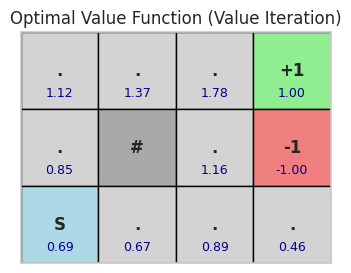

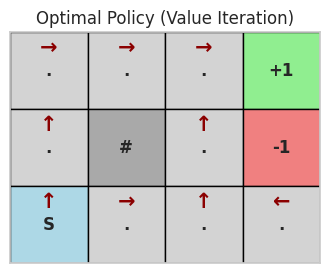


--- Comparison of Results ---
Are optimal value functions from PI and VI approximately equal? True
Are optimal policies from PI and VI identical? True


In [9]:
print("\n--- Part 3.2: Finding the Optimal Policy - Value Iteration ---")

def value_iteration(P, R, gamma, num_states, num_actions, theta=1e-6, max_iterations=1000):
    V = np.zeros(num_states) # Initialize value function to zeros

    print("Starting Value Iteration...")
    for i in range(max_iterations):
        delta = 0 # To check for convergence
        for s_idx in range(num_states):
            v_old = V[s_idx]

            # For terminal states, their value is fixed
            if idx_to_state[s_idx] == GOAL_STATE_COORD:
                V[s_idx] = GOAL_REWARD
                continue
            if idx_to_state[s_idx] == TRAP_STATE_COORD:
                V[s_idx] = TRAP_REWARD
                continue

            # Calculate Q-values for all actions from current state s_idx
            q_values = np.zeros(num_actions)
            for a_idx in range(num_actions):
                sum_of_future_values = 0
                for s_prime_idx in range(num_states):
                    prob = P[s_idx, a_idx, s_prime_idx]
                    reward = R[s_idx, a_idx, s_prime_idx]
                    sum_of_future_values += prob * (reward + gamma * V[s_prime_idx])
                q_values[a_idx] = sum_of_future_values

            V[s_idx] = np.max(q_values) # Update V(s) with the maximum Q-value
            delta = max(delta, abs(v_old - V[s_idx]))

        if delta < theta:
            print(f"Value Iteration converged after {i+1} iterations.")
            break
    else:
        print(f"Value Iteration did NOT converge within {max_iterations} iterations.")

    # Extract the optimal policy from the converged V*
    policy = np.zeros(num_states, dtype=int)
    for s_idx in range(num_states):
        if idx_to_state[s_idx] == GOAL_STATE_COORD or idx_to_state[s_idx] == TRAP_STATE_COORD:
            policy[s_idx] = ACTIONS.index('up') # Action doesn't matter for terminal states
            continue

        action_values = np.zeros(num_actions)
        for a_idx in range(num_actions):
            q_sa = 0
            for s_prime_idx in range(num_states):
                prob = P[s_idx, a_idx, s_prime_idx]
                reward = R[s_idx, a_idx, s_prime_idx]
                q_sa += prob * (reward + gamma * V[s_prime_idx])
            action_values[a_idx] = q_sa
        policy[s_idx] = np.argmax(action_values)

    return policy, V

# Run Value Iteration
optimal_policy_vi, optimal_V_vi = value_iteration(P, R, GAMMA, NUM_STATES, NUM_ACTIONS)

print(f"\nOptimal Value Function (Value Iteration):\n{optimal_V_vi}")
print(f"Optimal Policy (Value Iteration):\n{optimal_policy_vi}")

# Visualize the optimal value function and policy from Value Iteration
plot_grid(values=optimal_V_vi, title="Optimal Value Function (Value Iteration)")
plot_grid(policy=optimal_policy_vi, title="Optimal Policy (Value Iteration)")

print("\n--- Comparison of Results ---")
print(f"Are optimal value functions from PI and VI approximately equal? {np.allclose(optimal_V_pi, optimal_V_vi, atol=1e-4)}")
print(f"Are optimal policies from PI and VI identical? {np.array_equal(optimal_policy_pi, optimal_policy_vi)}")

# Note: Policies might not be exactly identical if multiple actions yield the same max Q-value.
# np.argmax picks the first one encountered. But the resulting value function should be the same.

**Discussion Points:**
* Describe the fundamental difference in approach between Policy Iteration and Value Iteration.
* Which algorithm (Policy Iteration or Value Iteration) typically converges faster in practice, and why? Under what conditions might one be preferred over the other?
* Explain how the optimal policy is derived from the optimal value function $V^*(s)$ in Value Iteration.

### Part 4: Advanced Topics & Discussion 

This section is for broader discussion and conceptual understanding, extending beyond direct coding.

**Discussion Topics:**
* **Markov Property:** Reiterate and discuss the importance and implications of the Markov property for MDPs.
* **Bellman Equations:** Explain the Bellman optimality equations for $V^*(s)$ and $Q^*(s)$ and their role in dynamic programming solutions.
* **Discount Factor ($\gamma$):** Discuss the role of the discount factor and how it influences the policy.
* **Finite vs. Infinite Horizon MDPs:** Differentiate between these two types of MDPs and their common solution approaches.
* **MDPs and Reinforcement Learning:** Explain the fundamental relationship between MDPs as the mathematical framework and Reinforcement Learning as the set of algorithms used to solve MDPs when the environment dynamics (transitions, rewards) are unknown.
* **Limitations of MDPs:** Discuss practical limitations such as the "curse of dimensionality" and the requirement for a known environment model.




* **Markov Property:**
    The Markov Property is the cornerstone of MDPs. It states that the future is conditionally independent of the past, given the present state and action. Mathematically, this means:
    $$P(s_{t+1}, r_{t+1} | s_t, a_t, s_{t-1}, a_{t-1}, \ldots, s_0, a_0) = P(s_{t+1}, r_{t+1} | s_t, a_t)$$
    In simpler terms, once you know the current state ($s_t$) and the action taken ($a_t$), all the information needed to predict the next state ($s_{t+1}$) and the reward ($r_{t+1}$) is contained within that current state-action pair. The history leading up to $s_t$ does not provide any additional relevant information.

    **Implications:**
    * **Simplification:** This property significantly simplifies the modeling of sequential decision-making problems, allowing for efficient algorithms like dynamic programming. Without it, the state space would need to encode the entire history, leading to an intractable "history problem."
    * **Foundation for DP and RL:** It is the fundamental assumption that enables Bellman equations and forms the basis for most dynamic programming and reinforcement learning algorithms.
    * **Potential Limitation:** In many real-world scenarios, the true underlying process might *not* be perfectly Markovian (e.g., poker, where knowing past hands is crucial). For such problems, we might need to augment the state definition to include relevant history or use more complex models like Partially Observable MDPs (POMDPs).

* **Bellman Equations:**
    The Bellman equations are a set of recursive equations that define the value functions in an MDP. They are crucial because they break down the complex problem of finding optimal policies over an infinite horizon into simpler, iterative calculations.

    * **Bellman Expectation Equation (for a given policy $\pi$):**
        $$V^\pi(s) = \sum_{a \in A} \pi(a|s) \sum_{s' \in S} P(s'|s,a) [R(s,a,s') + \gamma V^\pi(s')]$$
        This equation describes the value of a state $s$ when following a fixed policy $\pi$. It states that the value of being in state $s$ is the expected immediate reward plus the discounted expected value of the next state, averaged over all possible actions determined by $\pi$ and all possible next states. This is used in the Policy Evaluation step of Policy Iteration.

    * **Bellman Optimality Equation (for the optimal value function $V^*(s)$):**
        $$V^*(s) = \max_a \sum_{s' \in S} P(s'|s,a) [R(s,a,s') + \gamma V^*(s')]$$
        This equation defines the maximum possible value achievable from state $s$. It says that the optimal value of state $s$ is the maximum over all possible actions of the expected immediate reward plus the discounted optimal expected value of the next state. This is used directly in Value Iteration.

    * **Bellman Optimality Equation (for the optimal action-value function $Q^*(s,a)$):**
        $$Q^*(s,a) = \sum_{s' \in S} P(s'|s,a) [R(s,a,s') + \gamma \max_{a'} Q^*(s',a')]$$
        The $Q^*(s,a)$ function represents the maximum expected return achievable by taking action $a$ in state $s$ and then following the optimal policy thereafter. This is particularly important for model-free reinforcement learning algorithms like Q-learning, where the optimal policy is derived directly from $Q^*(s,a)$ without explicitly calculating $V^*(s)$.

* **Discount Factor ($\gamma$):**
    The discount factor $\gamma \in [0, 1]$ is a crucial parameter that determines the present value of future rewards.
    * A $\gamma$ closer to 0 (e.g., 0.1) means the agent is "myopic" or "short-sighted," prioritizing immediate rewards much more heavily than future rewards.
    * A $\gamma$ closer to 1 (e.g., 0.99) means the agent is "far-sighted," considering future rewards almost as important as immediate ones. This encourages long-term planning and can lead to policies that take longer paths to achieve much larger cumulative rewards.
    * If $\gamma = 0$, the agent only considers the immediate reward.
    * If $\gamma = 1$ (undiscounted), the sum of rewards might diverge if there are infinite sequences without termination, or if there's a positive reward loop. For infinite-horizon problems, $\gamma < 1$ is generally required to ensure convergence of the value function.

* **Finite vs. Infinite Horizon MDPs:**
    * **Finite Horizon MDPs:** These MDPs have a fixed number of time steps (or a finite number of decisions) before the process terminates. The optimal policy can be time-dependent (i.e., the best action might change depending on how many steps are left). They are typically solved using backward induction, starting from the final time step and working backward.
    * **Infinite Horizon MDPs:** These MDPs continue indefinitely, without a predefined end time. The goal is to maximize the expected *discounted* cumulative reward. If the environment is stationary (transition probabilities and rewards don't change over time) and the discount factor $\gamma < 1$, the optimal policy for an infinite-horizon MDP is typically stationary (time-independent), meaning the best action in a given state remains the same regardless of time. Policy Iteration and Value Iteration are designed to solve infinite-horizon, discounted MDPs.

* **MDPs and Reinforcement Learning:**
    MDPs provide the **mathematical framework** for Reinforcement Learning (RL).
    * **MDPs are "planning" problems:** When we have a **model of the environment** (i.e., we know $P(s'|s,a)$ and $R(s,a,s')$), we can solve the MDP using dynamic programming algorithms (like Policy Iteration and Value Iteration, as demonstrated in this lab) to find the optimal policy offline. This is akin to an agent sitting down and "thinking" about the best strategy without interacting with the real world.
    * **Reinforcement Learning is "learning" from experience:** In RL, the agent does *not* know the environment's dynamics ($P$ and $R$). Instead, it learns the optimal policy by *interacting* with the environment (trial and error), collecting experience (state, action, reward, next state tuples), and updating its policy or value function based on these experiences. Algorithms like Q-learning, SARSA, and deep reinforcement learning methods are used for this purpose.
    * Essentially, RL is about solving MDPs when the MDP model is unknown.

* **Limitations of MDPs:**
    Despite their power, MDPs have practical limitations:
    * **Curse of Dimensionality:** This is perhaps the most significant limitation. As the number of states ($|S|$) or actions ($|A|$) increases, the computational complexity of solving MDPs (especially for dynamic programming) grows dramatically. The time and memory required can become prohibitive (exponentially or polynomially in $|S|$ and $|A|$). For example, a robot's state might involve continuous joint angles, sensor readings, etc., leading to an astronomically large or even infinite state space.
    * **Requirement for a Known Model:** Dynamic programming methods require complete knowledge of the transition probabilities $P(s'|s,a)$ and reward function $R(s,a,s')$. In many real-world scenarios, this model is unknown or too complex to define explicitly. This is precisely why Reinforcement Learning became a separate field.
    * **Strict Markov Property:** As discussed, the assumption that the future depends only on the current state can be violated in complex environments where history or unobserved factors play a crucial role. This leads to the need for Partially Observable MDPs (POMDPs) or state augmentation.
    * **Stationarity Assumption:** HMMs (Hidden Markov Models) and MDPs typically assume that the transition and reward dynamics are stationary (do not change over time). Many real-world problems are non-stationary, requiring adaptive learning algorithms.


---
  
<center>

<span style="color:#1f4e79">

Prepared By

**<span style="font-size:1.5em">Md. Atikuzzaman</span>**  
Lecturer  
Department of Computer Science and Engineering  
Green University of Bangladesh  
Email: atik@cse.green.edu.bd  

</span>
</center>

---
